In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from resources.plotting import Plotter
from tqdm.autonotebook import tqdm

from nltk.tokenize import WordPunctTokenizer

from nltk.translate.bleu_score import sentence_bleu
from rouge_score.rouge_scorer import RougeScorer
from resources.bart_score import BARTScorer
from resources.auc_score import AUCScorer
from resources.testing import PearsonCorrelationTester
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
MODELS = {
    "Gemma 1.1 - 2B": "google/gemma-1.1-2b-it",
    "Gemma 1.1 - 7B": "google/gemma-1.1-7b-it",
    "Gemma 2.0 - 9B": "google/gemma-2-9b-it",
#    "Gemma 2.0 - 27B":  "google/gemma-2-27b-it",
    "Llama 3.1 - 8B": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "Llama 3.2 - 1B": "meta-llama/Llama-3.2-1B-Instruct",
    "Llama 3.2 - 3B": "meta-llama/Llama-3.2-3B-Instruct"
}

PLOTS_DIR  = "plots"

# Load results:

In [3]:
RESULTS = {}

for key in MODELS:
    t_start = time.time()
    with open(f'results/movies/{MODELS[key]}.pkl', 'rb') as file:
        RESULTS[key] = pickle.load(file)
    print(f'Loaded {key} ({len(RESULTS[key]):d} instances, dt={(time.time()-t_start)*1000:.2f} ms).')

Loaded Gemma 1.1 - 2B (200 instances, dt=643.72 ms).
Loaded Gemma 1.1 - 7B (200 instances, dt=652.35 ms).
Loaded Gemma 2.0 - 9B (200 instances, dt=824.49 ms).
Loaded Llama 3.1 - 8B (200 instances, dt=627.46 ms).
Loaded Llama 3.2 - 1B (200 instances, dt=623.18 ms).
Loaded Llama 3.2 - 3B (200 instances, dt=625.25 ms).


In [4]:
pearson = PearsonCorrelationTester()
plotter = Plotter(RESULTS, i_sample=6, save_dir=PLOTS_DIR)
scorer  = AUCScorer(RESULTS)
plotter.print_chat("Llama 3.1 - 8B")

\begin{tabular}{p{.05\linewidth}p{.1\linewidth}p{.8\linewidth}}

\hline

&
\textbf{user}: &
\texttt{What is the sentiment of the following review?

"Hints are made to the audience that this film could be a blast. Alas, these are only hints."

Assign one of the following labels: "negative" or "positive". Make sure to answer only with the label or "none" if none of them applies.} \\

&
\textbf{assistant}: &
\texttt{negative} \\


\hline

&
\textbf{user}: &
\texttt{What is the most important phrase of the review influencing your assessment? Provide only the phrase as a string.} \\

&
\textbf{assistant}: &
\texttt{"Alas, these are only hints"} \\


\hline

&
\textbf{user}: &
\texttt{Provide a version of the announcement that would alter your assessment to "positive" while changing as few words in the original announcement as possible.} \\

&
\textbf{assistant}: &
\texttt{"Hints are made to the audience that this film could be a blast. Happily, these are more than hints."

In this revised v

# Performance:

In [5]:
for model in RESULTS:
    y_true = np.array([(item['label']['text'] == 'positive', item['label']['text'] == 'negative') for item in RESULTS[model]], dtype=float)
    y_pred = np.array([(item['prediction']['text'] == 'positive', item['prediction']['text'] == 'negative') for item in RESULTS[model]], dtype=float)

    print(model)
    print(f'  F1:           {f1_score(y_true, y_pred, average="macro"):.2f}')
    print(f'  precision:    {precision_score(y_true, y_pred, average="macro"):.2f}')
    print(f'  recall:       {recall_score(y_true, y_pred, average="macro"):.2f}')
    print()

Gemma 1.1 - 2B
  F1:           0.85
  precision:    0.92
  recall:       0.81

Gemma 1.1 - 7B
  F1:           0.91
  precision:    0.91
  recall:       0.91

Gemma 2.0 - 9B
  F1:           0.95
  precision:    0.97
  recall:       0.94

Llama 3.1 - 8B
  F1:           0.96
  precision:    0.97
  recall:       0.96

Llama 3.2 - 1B
  F1:           0.85
  precision:    0.87
  recall:       0.85

Llama 3.2 - 3B
  F1:           0.89
  precision:    0.91
  recall:       0.88



# Faithfullness:

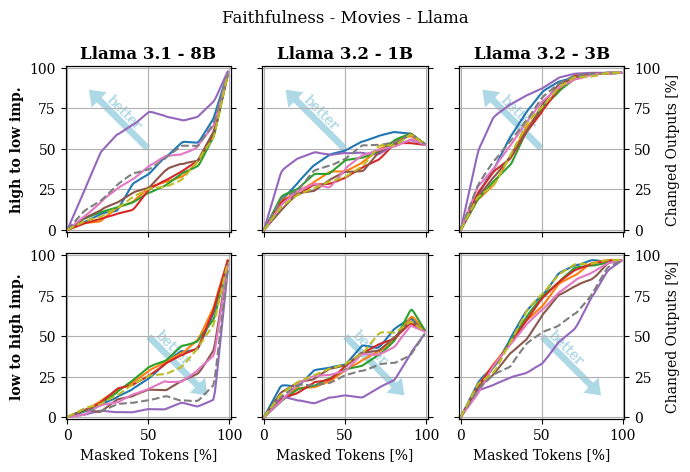

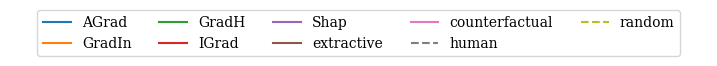

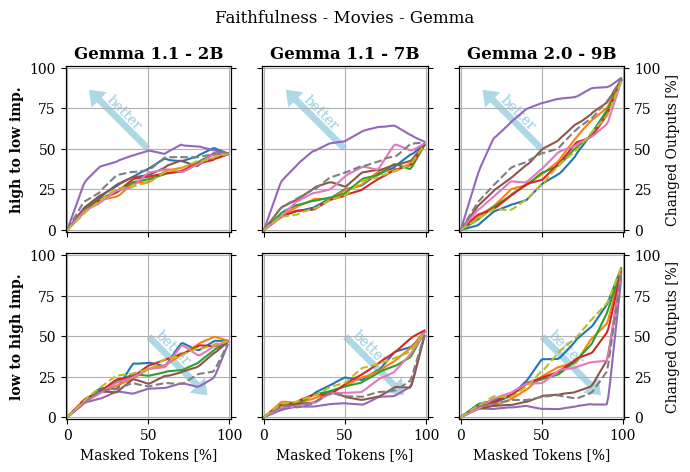

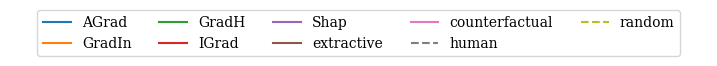

,Gemma 1.1 - 2B,Gemma 1.1 - 7B,Gemma 2.0 - 9B,Llama 3.1 - 8B,Llama 3.2 - 1B,Llama 3.2 - 3B
AGrad,0.039837,0.018643,-0.006637,0.066877,0.082227,0.037692
GradIn,0.007651,0.033408,0.115518,-0.039092,0.063251,0.014959
GradH,0.042171,0.051122,0.081918,-0.035949,0.082674,0.001211
IGrad,0.004948,-0.007783,0.096440,-0.028360,0.023941,0.018068
Shap,0.256413,0.388971,0.592499,0.507359,0.274752,0.365649
human,0.150311,0.189085,0.314800,0.254069,0.148651,0.193770
extractive,0.090212,0.157138,0.304870,0.111459,0.010166,0.083762
counterfactual,0.019379,0.128729,0.152128,0.169504,0.047460,0.076972


In [6]:
plotter.plot_perturbation(f'Faithfulness - Movies')
scorer.score_table()

Gemma 1.1 - 2B

In [7]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma 1.1 - 2B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['positive<eos>', '1600']], dtype='<U21')

Gemma 1.1 - 7B

In [8]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma 1.1 - 7B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['negative<eos>', '8'],
       ['positive<eos>', '1592']], dtype='<U21')

Gemma 2.0 - 9B

In [9]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma 2.0 - 9B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['none \n<end_of_turn><eos>', '1136'],
       ['please provide the review text. \n', '416'],
       ['positive \n<end_of_turn><eos>', '48']], dtype='<U33')

Llama 3.1 - 8B

In [10]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Llama 3.1 - 8B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['none<|eot_id|>', '1600']], dtype='<U21')

Llama 3.2 - 1B

In [11]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Llama 3.2 - 1B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['negative<|eot_id|>', '1160'],
       ['none<|eot_id|>', '8'],
       ['positive<|eot_id|>', '432']], dtype='<U21')

Llama 3.2 - 3B

In [12]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Llama 3.2 - 3B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['"none"<|eot_id|>', '1472'],
       ['It seems like the review is empty.', '8'],
       ["It seems like there's a formatting issue", '24'],
       ["It seems like there's a lot of", '8'],
       ['None<|eot_id|>', '72'],
       ['The review is "none". There is', '16']], dtype='<U40')

# Self assessment:

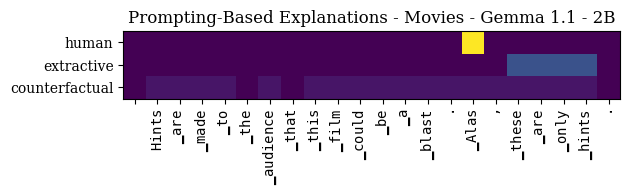

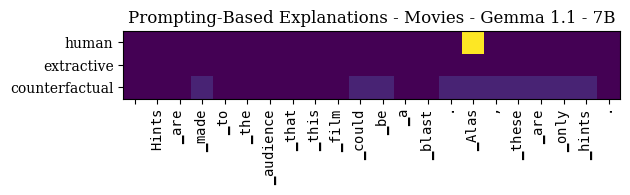

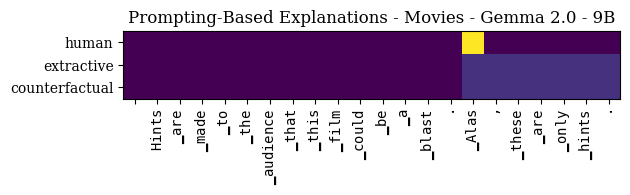

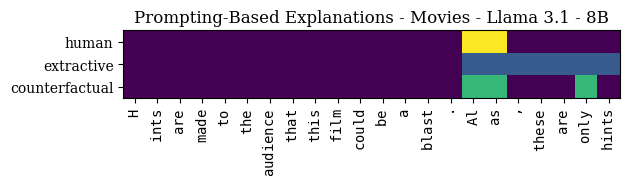

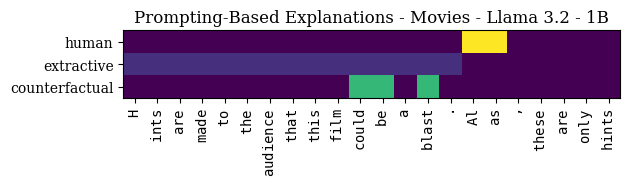

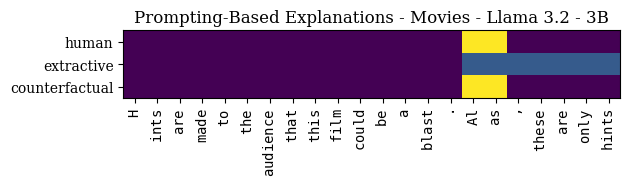

In [13]:
importance_human = {model:[] for model in RESULTS}
importance_self  = {model:[] for model in RESULTS}
importance_cf    = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        length = r['sample']['end'] - r['sample']['start']
        offset = r['sample']['start']
        
        importance_human[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['human']: 
            importance_human[model][-1][i-offset:j-offset] = 1.
        importance_human[model][-1] /= max(importance_human[model][-1].sum(), 1e-9)
        
        importance_self[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['extractive'][:len(r['spans']['human'])]:
            importance_self[model][-1][i-offset:j-offset] = 1.
        importance_self[model][-1] /= max(importance_self[model][-1].sum(), 1e-9)
        
        importance_cf[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['counterfactual']:
            importance_cf[model][-1][i-offset:j-offset] = 1.
        importance_cf[model][-1] /= max(importance_cf[model][-1].sum(), 1e-9)

plotter.plot_importance([importance_human, importance_self, importance_cf], ['human', 'extractive', 'counterfactual'], f'Prompting-Based Explanations - Movies')
pearson.add(importance_human, 'human')
pearson.add(importance_self,  'extractive')
pearson.add(importance_cf,    'counterfactual')

# AGrad:

Gemma 1.1 - 2B 0.9894347895580933
Gemma 1.1 - 7B 0.9961904266132804
Gemma 2.0 - 9B 0.8182982167387876
Llama 3.1 - 8B 0.4752679123917829
Llama 3.2 - 1B 0.42789252001254796
Llama 3.2 - 3B 0.5560534275024458


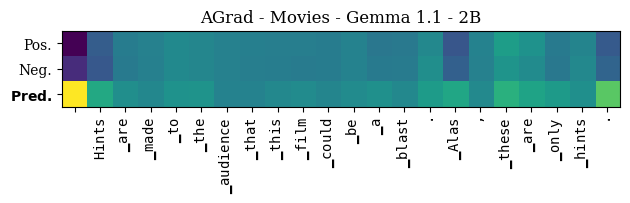

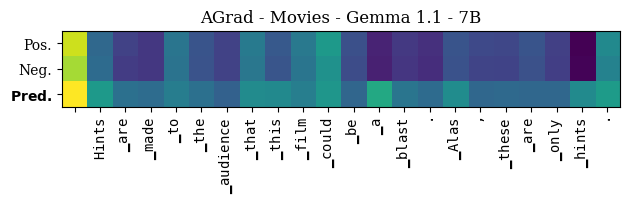

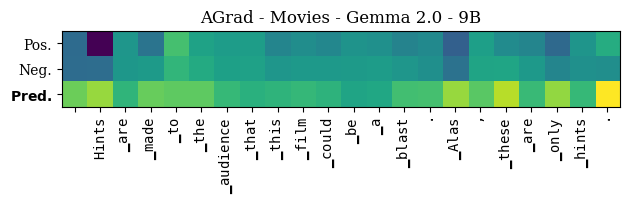

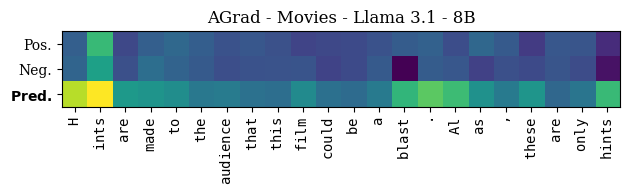

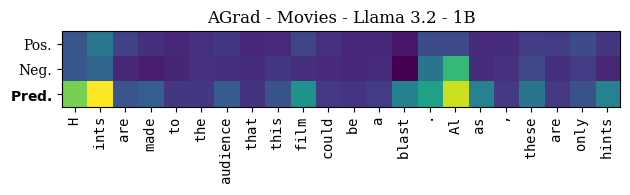

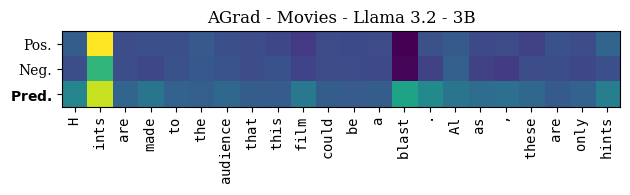

In [14]:
importance_agrad_pos = {model:[] for model in RESULTS}
importance_agrad_neg = {model:[] for model in RESULTS}
importance_agrad_cls = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        x_start = r['sample']['start']
        x_end   = r['sample']['end']

        # get prediction:
        y       = r['prediction']['text'] == 'positive'

        pos  = r['AGrad'][:, 1, x_start:x_end]
        neg  = r['AGrad'][:, 0, x_start:x_end]
        cls  = np.abs(pos if y else neg)

        importance_agrad_pos[model].append(pos.mean(axis=0))
        importance_agrad_neg[model].append(neg.mean(axis=0))
        importance_agrad_cls[model].append(cls.mean(axis=0))

    print(model, np.nanmean(pearson.correlate(importance_agrad_pos[model], importance_agrad_neg[model])[0]))

plotter.plot_importance([importance_agrad_pos, importance_agrad_neg, importance_agrad_cls], ['Pos.', 'Neg.', '$\\bf{Pred.}$'], f'AGrad - Movies')
pearson.add(importance_agrad_cls, 'AGrad')

# GradIn

Gemma 1.1 - 2B -1.0
Gemma 1.1 - 7B -1.0
Gemma 2.0 - 9B -1.0
Llama 3.1 - 8B -1.0
Llama 3.2 - 1B -1.0
Llama 3.2 - 3B -1.0


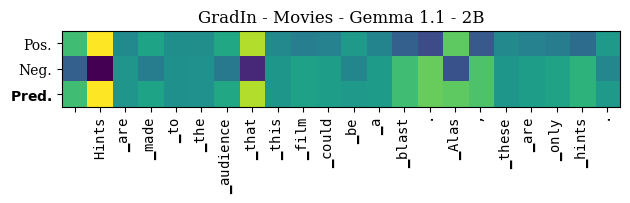

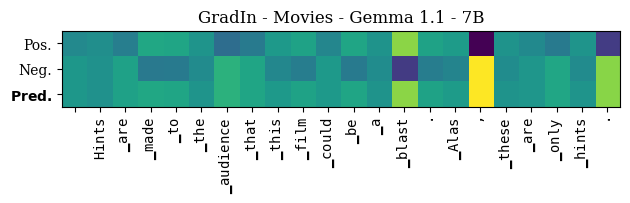

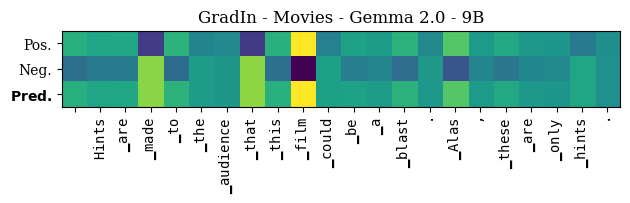

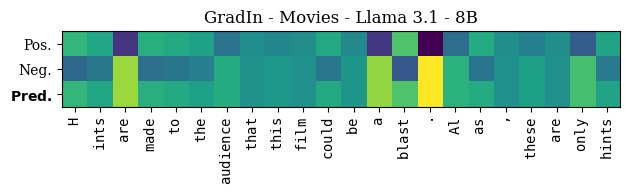

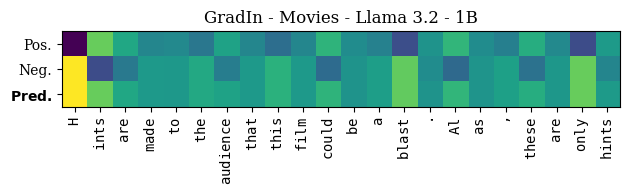

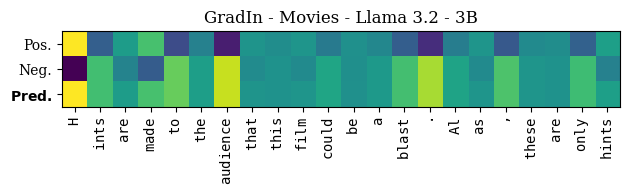

In [15]:
importance_gradin_pos  = {model:[] for model in RESULTS}
importance_gradin_neg  = {model:[] for model in RESULTS}
importance_gradin_cls  = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        x_start = r['sample']['start']
        x_end   = r['sample']['end']

        # get prediction:
        y       = r['prediction']['text'] == 'positive'

        pos  = r['GradIn'][1, x_start:x_end]
        neg  = r['GradIn'][0, x_start:x_end]
        cls  = np.abs(pos if y else neg)

        importance_gradin_pos[model].append(pos.T)
        importance_gradin_neg[model].append(neg.T)
        importance_gradin_cls[model].append(cls.T)

    print(model, np.nanmean(pearson.correlate(importance_gradin_pos[model], importance_gradin_neg[model])[0]))

plotter.plot_importance([importance_gradin_pos, importance_gradin_neg, importance_gradin_cls], ['Pos.', 'Neg.', '$\\bf{Pred.}$'], f'GradIn - Movies')
pearson.add(importance_gradin_cls, 'GradIn')

# GradH

Gemma 1.1 - 2B -1.0
Gemma 1.1 - 7B -1.0
Gemma 2.0 - 9B -1.0
Llama 3.1 - 8B -1.0
Llama 3.2 - 1B -1.0
Llama 3.2 - 3B -1.0


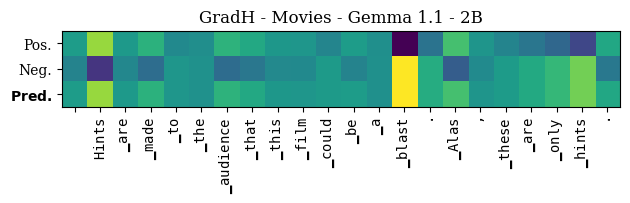

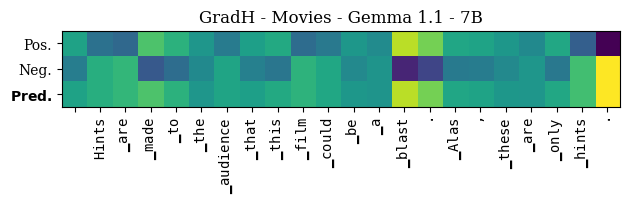

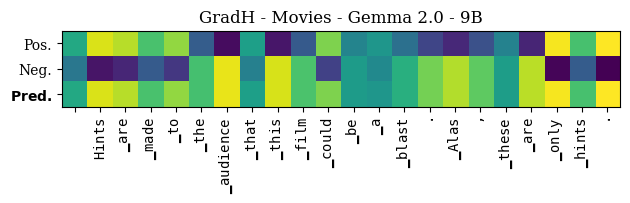

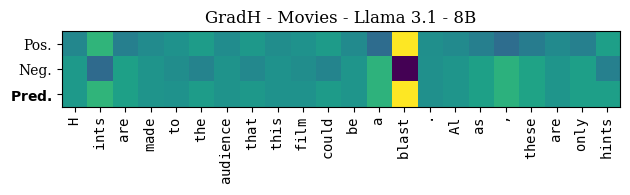

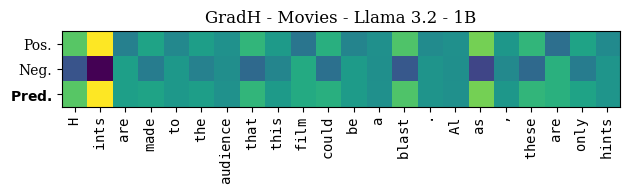

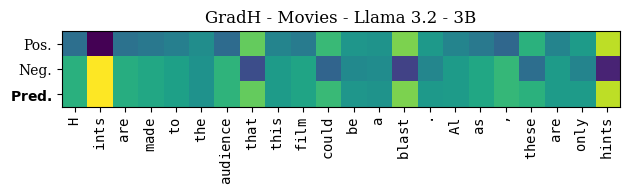

In [16]:
importance_gradh_pos  = {model:[] for model in RESULTS}
importance_gradh_neg  = {model:[] for model in RESULTS}
importance_gradh_cls  = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        x_start = r['sample']['start']
        x_end   = r['sample']['end']

        # get prediction:
        y       = r['prediction']['text'] == 'positive'

        pos  = r['GradH'][1, x_start:x_end]
        neg  = r['GradH'][0, x_start:x_end]
        cls  = np.abs(pos if y else neg)

        importance_gradh_pos[model].append(pos.T)
        importance_gradh_neg[model].append(neg.T)
        importance_gradh_cls[model].append(cls.T)

    print(model, np.nanmean(pearson.correlate(importance_gradh_pos[model], importance_gradh_neg[model])[0]))

plotter.plot_importance([importance_gradh_pos, importance_gradh_neg, importance_gradh_cls], ['Pos.', 'Neg.', '$\\bf{Pred.}$'], f'GradH - Movies')
pearson.add(importance_gradh_cls, 'GradH')

# Grad$^{-1}$

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)
/tmp/ipykernel_836846/1612172504.py:22: RuntimeWarning: Mean of empty slice
  print(model, np.nanmean(pearson.correlate(importance_igrad_pos[model], importance_igrad_neg[model])[0]))


Gemma 1.1 - 2B nan
Gemma 1.1 - 7B nan
Gemma 2.0 - 9B nan
Llama 3.1 - 8B nan
Llama 3.2 - 1B nan
Llama 3.2 - 3B nan


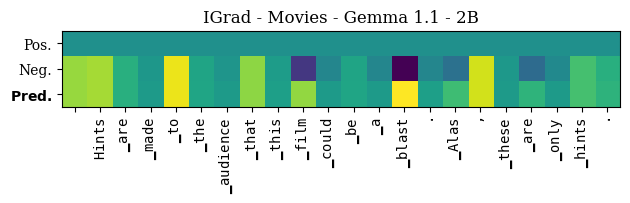

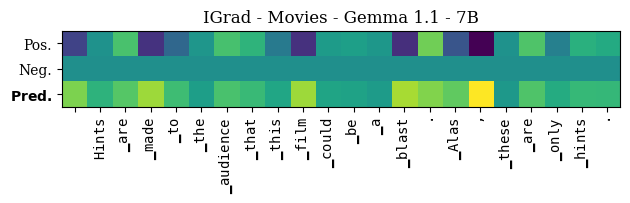

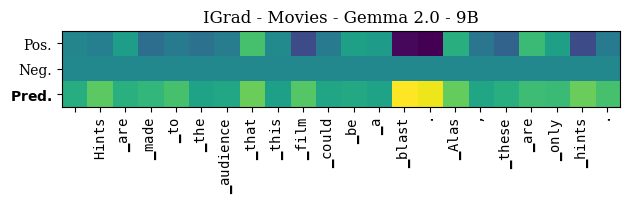

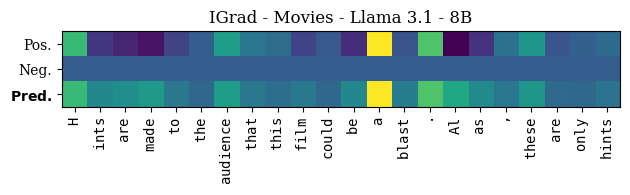

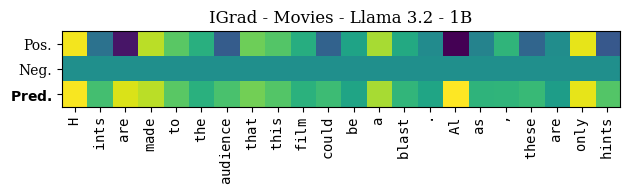

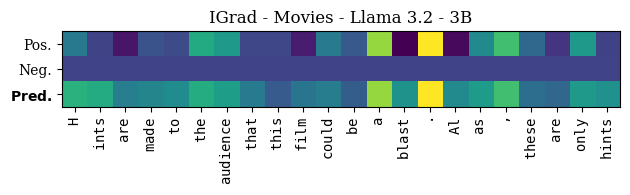

In [17]:
importance_igrad_pos  = {model:[] for model in RESULTS}
importance_igrad_neg  = {model:[] for model in RESULTS}
importance_igrad_cls  = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        x_start = r['sample']['start']
        x_end   = r['sample']['end']

        # get prediction:
        y       = r['prediction']['text'] == 'positive'

        pos  = r['IGrad'][1, x_start:x_end, :]
        neg  = r['IGrad'][0, x_start:x_end, :]
        cf   = np.abs(neg if y else pos)

        importance_igrad_pos[model].append(pos.mean(axis=-1).T)
        importance_igrad_neg[model].append(neg.mean(axis=-1).T)
        importance_igrad_cls[model].append(cf.mean(axis=-1).T)

    print(model, np.nanmean(pearson.correlate(importance_igrad_pos[model], importance_igrad_neg[model])[0]))

plotter.plot_importance([importance_igrad_pos, importance_igrad_neg, importance_igrad_cls],['Pos.', 'Neg.', '$\\bf{Pred.}$'], f'IGrad - Movies')
pearson.add(importance_igrad_cls, 'IGrad')

# Shap:

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


Gemma 1.1 - 2B -0.32666213611018585
Gemma 1.1 - 7B -0.7284418484658371
Gemma 2.0 - 9B -0.44087122509305127
Llama 3.1 - 8B -0.5758515597844768
Llama 3.2 - 1B -0.5175388294277734
Llama 3.2 - 3B -0.3724449281947682


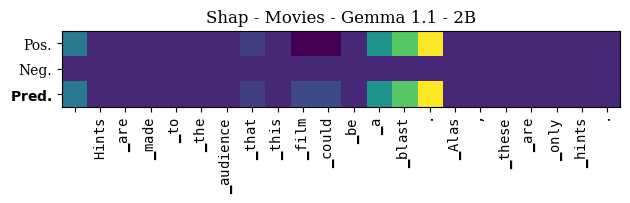

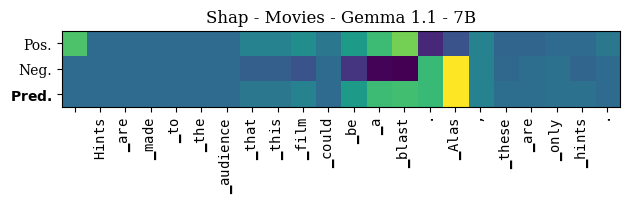

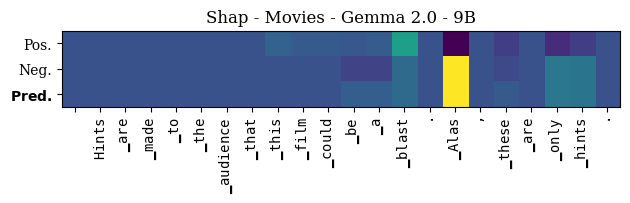

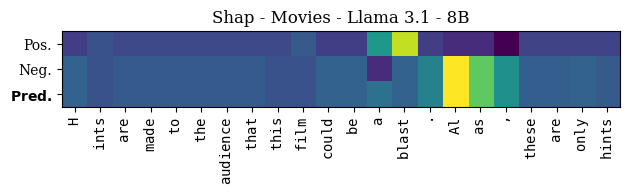

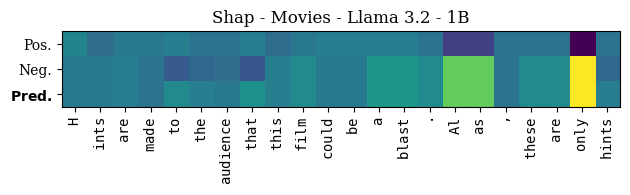

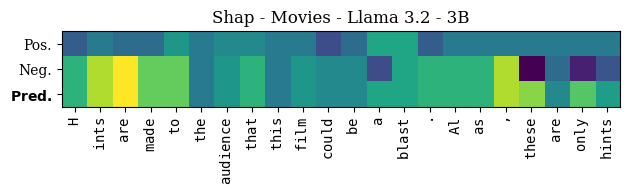

In [18]:
importance_shap_pos  = {model:[] for model in RESULTS}
importance_shap_neg  = {model:[] for model in RESULTS}
importance_shap_cls  = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        x_start = r['sample']['start']
        x_end   = r['sample']['end']

        # get prediction:
        y       = r['prediction']['text'] == 'positive'

        pos  = r['Shap'][1, x_start:x_end]
        neg  = r['Shap'][0, x_start:x_end]
        cls  = np.abs(pos if y else neg)

        importance_shap_pos[model].append(pos.T)
        importance_shap_neg[model].append(neg.T)
        importance_shap_cls[model].append(cls.T)

    print(model, np.nanmean(pearson.correlate(importance_shap_pos[model], importance_shap_neg[model])[0]))

plotter.plot_importance([importance_shap_pos, importance_shap_neg, importance_shap_cls], ['Pos.', 'Neg.', '$\\bf{Pred.}$'], f'Shap - Movies')
pearson.add(importance_shap_cls, 'Shap')

/tmp/ipykernel_836846/2557847837.py:1: RuntimeWarning: invalid value encountered in divide
  scale = lambda d: {key: [(x - np.min(x)) / (np.max(x) - np.min(x)) for x in d[key]] for key in d}


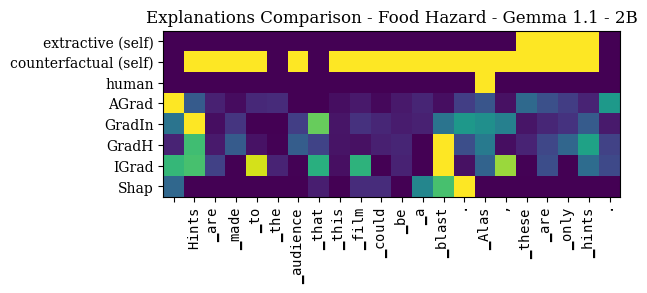

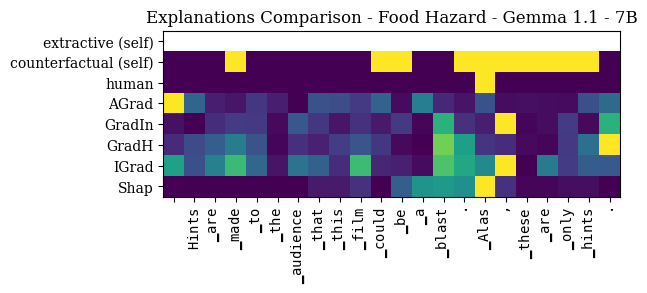

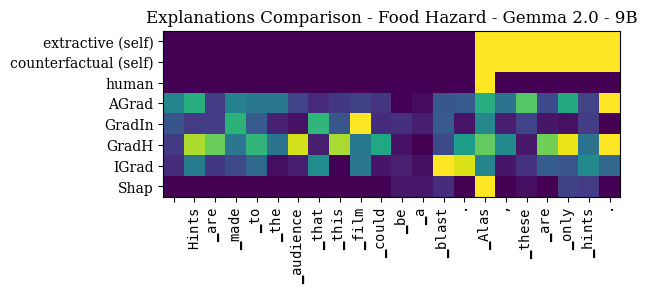

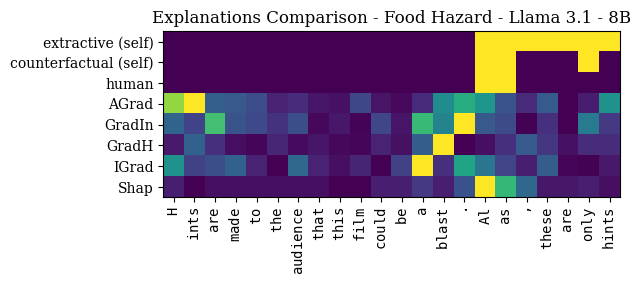

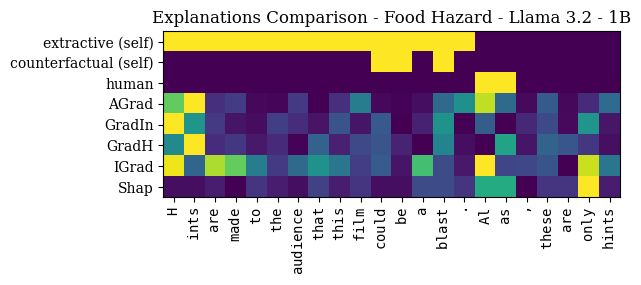

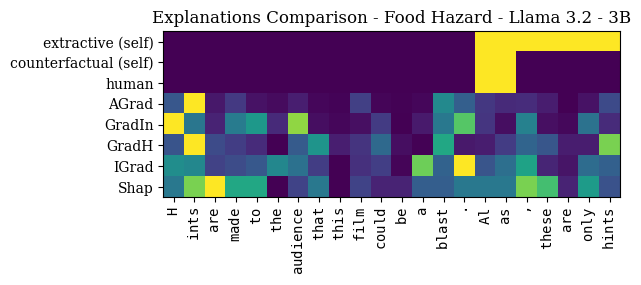

In [19]:
scale = lambda d: {key: [(x - np.min(x)) / (np.max(x) - np.min(x)) for x in d[key]] for key in d}
plotter.plot_importance(
    [
        scale(importance_self),
        scale(importance_cf),
        scale(importance_human),
        scale(importance_agrad_cls),
        scale(importance_gradin_cls),
        scale(importance_gradh_cls),
        scale(importance_igrad_cls),
        scale(importance_shap_cls)
    ],
    ['extractive (self)', 'counterfactual (self)', 'human', 'AGrad', 'GradIn', 'GradH', 'IGrad', 'Shap'],
    f'Explanations Comparison - Food Hazard'
)

# Correlations:

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


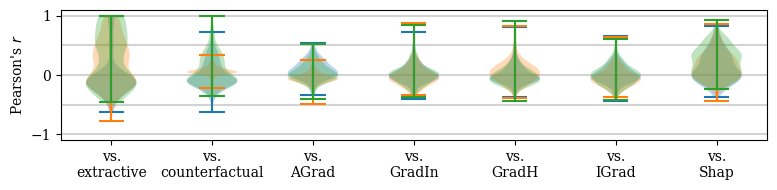

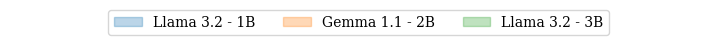

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


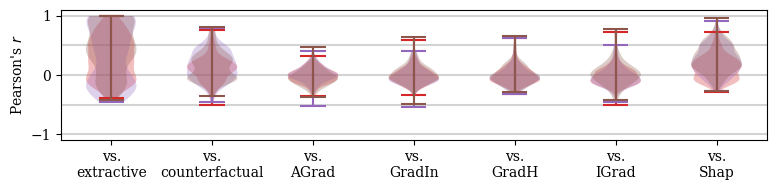

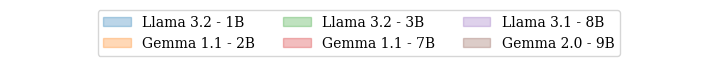

In [20]:
pearson.boxplot('human', path=f'{PLOTS_DIR}/PearsonViolin - Movies - Human.pdf')

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


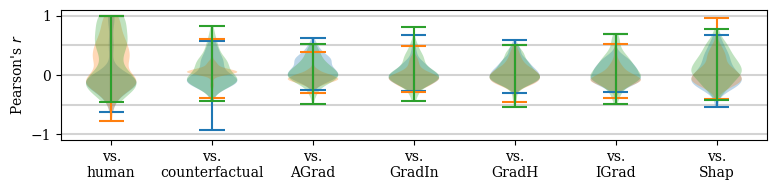

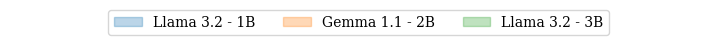

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


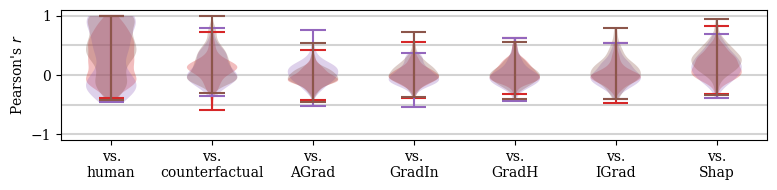

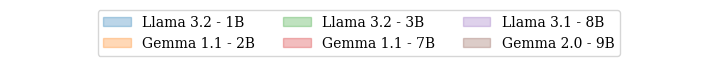

In [21]:
pearson.boxplot('extractive', path=f'{PLOTS_DIR}/PearsonViolin - Movies - Self.pdf')

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


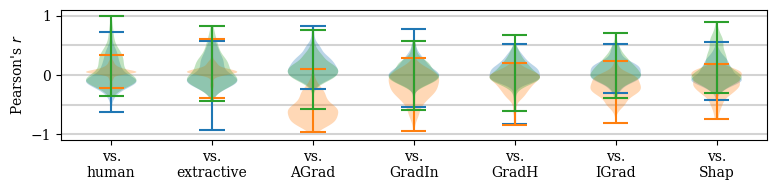

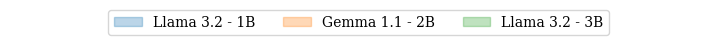

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


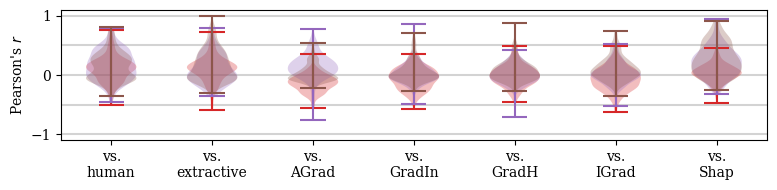

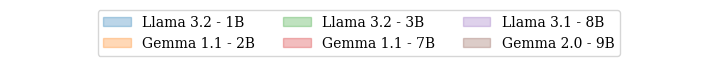

In [22]:
pearson.boxplot('counterfactual', path=f'{PLOTS_DIR}/PearsonViolin - Movies - Counterfactual.pdf')

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


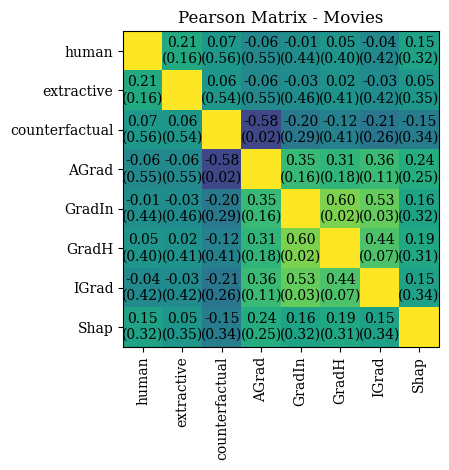

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


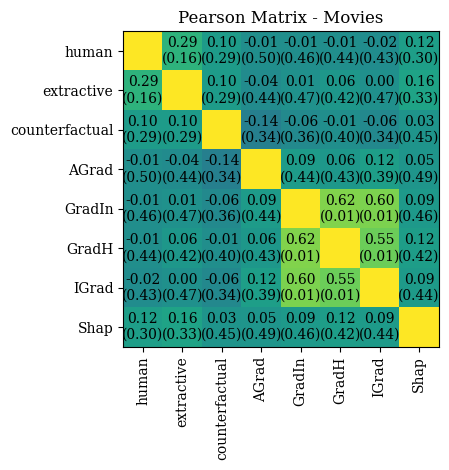

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


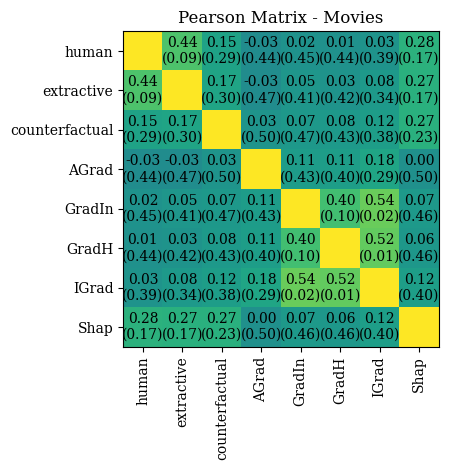

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


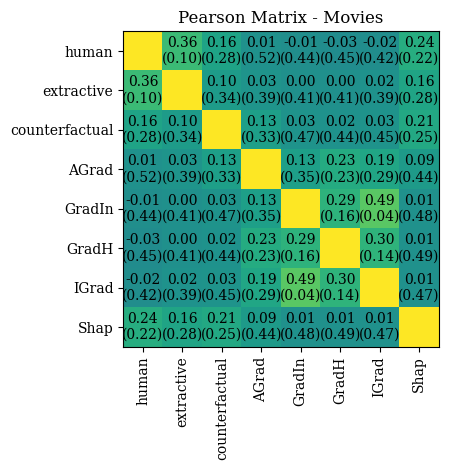

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


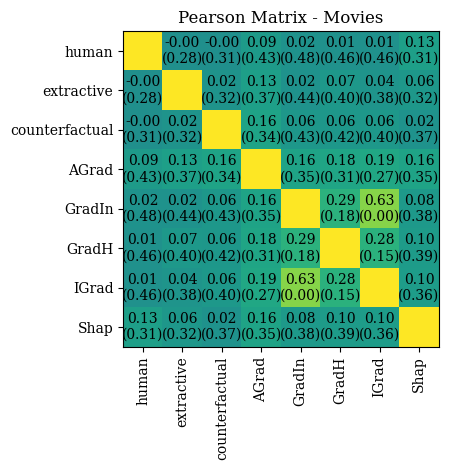

/home/h21/kora8563/explainability/resources/testing.py:231: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


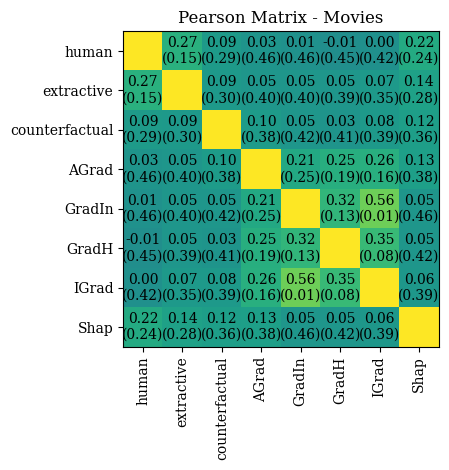

In [23]:
pearson.matrixplot(title='Pearson Matrix - Movies', dir=PLOTS_DIR)

# Counterfactual:

/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or us

Gemma 1.1 - 2B
  Success rate: 0.975
  Similarity: 0.6024707902004213
  BLEU: 0.11041092626625679
  ROUGE-1: 0.021444564386901715
  ROUGE-L: 0.08261572330894527
  BART: -6.0730538129806515

Gemma 1.1 - 7B
  Success rate: 0.97
  Similarity: 0.6991347914842773
  BLEU: 0.5137775162628386
  ROUGE-1: 0.24729149979834555
  ROUGE-L: 0.4421982667227862
  BART: -2.6778108277886186

Gemma 2.0 - 9B
  Success rate: 0.525
  Similarity: 0.9557594746445373
  BLEU: 0.9143329536873959
  ROUGE-1: 0.853321241551896
  ROUGE-L: 0.9127302229738143
  BART: -1.1483613272507986

Llama 3.1 - 8B
  Success rate: 0.91
  Similarity: 0.797560054596434
  BLEU: 0.6981207894719899
  ROUGE-1: 0.5428177212953381
  ROUGE-L: 0.6697568341851476
  BART: -3.066621164371679

Llama 3.2 - 1B
  Success rate: 0.525
  Similarity: 0.7734159859834016
  BLEU: 0.6596962983794213
  ROUGE-1: 0.5004268958889643
  ROUGE-L: 0.6292369751351363
  BART: -2.9583827779406593

Llama 3.2 - 3B
  Success rate: 0.51
  Similarity: 0.8398306983657622
 

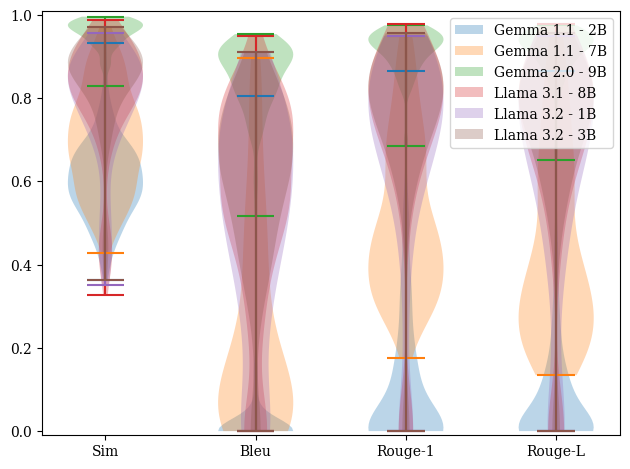

In [27]:
wp_tokenizer = WordPunctTokenizer()
rouge_scorer = RougeScorer(['rouge1', 'rougeL'], tokenizer=wp_tokenizer)
bart_scorer = BARTScorer(device='cuda:0', checkpoint='facebook/bart-large-cnn')

hs, ls = [], [] 
for model in RESULTS:
    counterfactuals = []

    for r in RESULTS[model]:
        cf = r['counterfactual']
        success = cf['prediction'] != r['prediction']['text']
    
        bleu = sentence_bleu([wp_tokenizer.tokenize(r['sample']['text'].lower())], wp_tokenizer.tokenize(cf['text'].lower()))
        rouge = rouge_scorer.score(r['sample']['text'].lower(), cf['text'].lower())
        bart = bart_scorer.score([r['sample']['text']], [cf['text'].lower()], batch_size=4)
        
        counterfactuals.append((
            int(success),
            cf['similarity'],
            bleu,                      # bleu
            rouge['rouge1'].fmeasure,  # rouge
            rouge['rougeL'].fmeasure,
            bart[0]
        ))
    
    counterfactuals = np.array(counterfactuals, dtype=float)

    hs.append(plt.violinplot(counterfactuals[counterfactuals[:,0] == 1., 1:-1])['bodies'][0])
    ls.append(model)

    print(model)
    print('  Success rate:', counterfactuals[:,0].mean())
    print('  Similarity:', counterfactuals[counterfactuals[:,0] == 1., 1].mean())
    print('  BLEU:', counterfactuals[counterfactuals[:,0] == 1., 3].mean())
    print('  ROUGE-1:', counterfactuals[counterfactuals[:,0] == 1., 2].mean())
    print('  ROUGE-L:', counterfactuals[counterfactuals[:,0] == 1., 4].mean())
    print('  BART:', counterfactuals[counterfactuals[:,0] == 1., 5].mean())
    print()

plt.ylim(bottom=-.01, top=1.01)
plt.xticks(ticks=[1, 2, 3, 4], labels=['Sim', 'Bleu', 'Rouge-1', 'Rouge-L'])
plt.legend(handles=hs, labels=ls)
plt.tight_layout()
plt.show()

/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/h21/kora8563/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or us

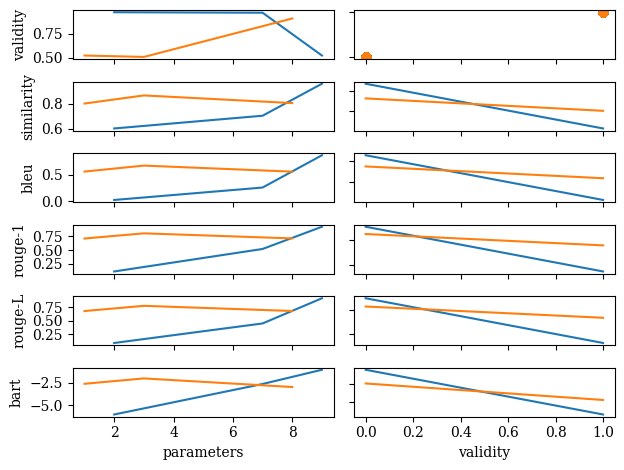

In [26]:
wp_tokenizer = WordPunctTokenizer()
rouge_scorer = RougeScorer(['rouge1', 'rougeL'], tokenizer=wp_tokenizer)
bart_scorer = BARTScorer(device='cuda:0', checkpoint='facebook/bart-large-cnn')

counterfactuals = []
for model in RESULTS:
    for r in RESULTS[model]:
        cf = r['counterfactual']
        success = cf['prediction'] != r['prediction']['text']

        bleu = sentence_bleu([wp_tokenizer.tokenize(r['sample']['text'].lower())], wp_tokenizer.tokenize(cf['text'].lower()))
        rouge = rouge_scorer.score(r['sample']['text'].lower(), cf['text'].lower())
        bart = bart_scorer.score([r['sample']['text']], [cf['text'].lower()], batch_size=4)

        counterfactuals.append({
            'type':       model.split()[0].lower(),
            'parameters': int(model[-2]),
#            'depth':      r['hidden_states'].shape[1],
            'validity':   int(success),
            'similarity': cf['similarity'],
            'bleu':       bleu,
            'rouge-1':    rouge['rouge1'].fmeasure,
            'rouge-L':    rouge['rougeL'].fmeasure,
            'bart':       bart[0]
        })

counterfactuals = pd.DataFrame(counterfactuals)
#columns_x = ['depth', 'parameters', 'validity']
columns_x = ['parameters', 'validity']
columns_y = ['validity', 'similarity', 'bleu', 'rouge-1', 'rouge-L', 'bart']

fig, axs = plt.subplots(len(columns_y), len(columns_x))
for i, x in enumerate(columns_x):
    for j, y in enumerate(columns_y):
        for tp in counterfactuals['type'].unique():
            values = counterfactuals[counterfactuals['type']==tp][[x, y]]

            if x != y:
                values = values.groupby(x).mean()
                axs[j,i].plot(values.index, values.values, label=tp)

            else: axs[j,i].scatter(values[x].values, values[y].values, label=tp)

        if j == len(columns_y)-1: axs[j,i].set_xlabel(x)
        else: axs[j,i].set_xticklabels([])

        if i == 0: axs[j,i].set_ylabel(y)
        else: axs[j,i].set_yticklabels([])

fig.tight_layout()
fig.show()